In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('train.csv')
# print(df.head())
print(df.describe())
no_of_features = len(df.columns) - 1
print(f'Number of features: {no_of_features}')
print(df.dtypes)


       minimum_nights  amenity_score  number_of_reviews  availability_365  \
count    40026.000000   40432.000000       40225.000000      40753.000000   
mean         7.002873      51.987233          23.648154        111.912178   
std         19.725353      19.459480          44.518303        131.273916   
min          1.000000      10.000000           0.000000          0.000000   
25%          1.000000      36.800000           1.000000          0.000000   
50%          3.000000      51.400000           5.000000         44.000000   
75%          5.000000      66.100000          24.000000        224.000000   
max       1000.000000      99.000000         607.000000        365.000000   

        price_class  
count  41348.000000  
mean       1.231619  
std        0.758579  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        2.000000  
max        3.000000  
Number of features: 6
neighbourhood_group        str
room_type                  str
minimum_nights         f

In [3]:
#identifying missing values
if df.isnull().values.any():
    print("There are missing values in the dataset.")
else:
    print("There are no missing values in the dataset.")
#handling missing values
df['amenity_score'] = df['amenity_score'].fillna(df['amenity_score'].mean())

#removes categorical missing values
categorical_cols = ['neighbourhood_group', 'room_type']
for col in categorical_cols:
    if col in df.columns:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        
#removes numerical missing values        
df['minimum_nights'] = df['minimum_nights'].fillna(df['minimum_nights'].median())
df['availability_365'] = df['availability_365'].fillna(df['availability_365'].median())
df['number_of_reviews'] = df['number_of_reviews'].fillna(0)
df['amenity_score'] = df['amenity_score'].fillna(0)
        
df.head()
        

There are missing values in the dataset.


,neighbourhood_group,room_type,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
0,Manhattan,Entire home/apt,2.0,82.5,15.0,254.0,3
1,Manhattan,Private room,2.0,53.7,1.0,0.0,1
2,Brooklyn,Private room,2.0,47.8,70.0,90.0,1
3,Manhattan,Entire home/apt,2.0,58.8,1.0,44.0,1
4,Bronx,Private room,2.0,32.2,0.0,89.0,1


In [4]:

num_cols = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']

df[num_cols] = df[num_cols].apply(lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1))

print("Normalization complete. First 5 rows of numerical data:")
print(df[num_cols].head())

Normalization complete. First 5 rows of numerical data:
   minimum_nights  number_of_reviews  availability_365  amenity_score
0       -0.251021          -0.181632          1.095640       1.585678
1       -0.251021          -0.499254         -0.849577       0.089009
2       -0.251021           1.066170         -0.160327      -0.217601
3       -0.251021          -0.499254         -0.512610       0.354044
4       -0.251021          -0.521941         -0.167985      -1.028297


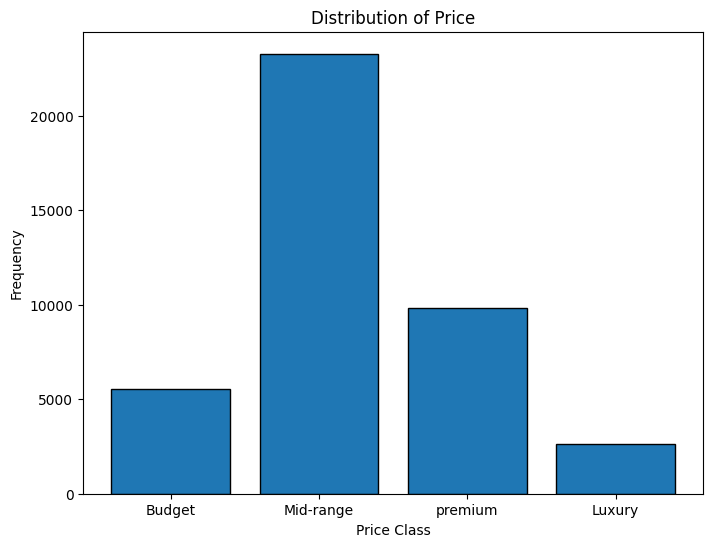

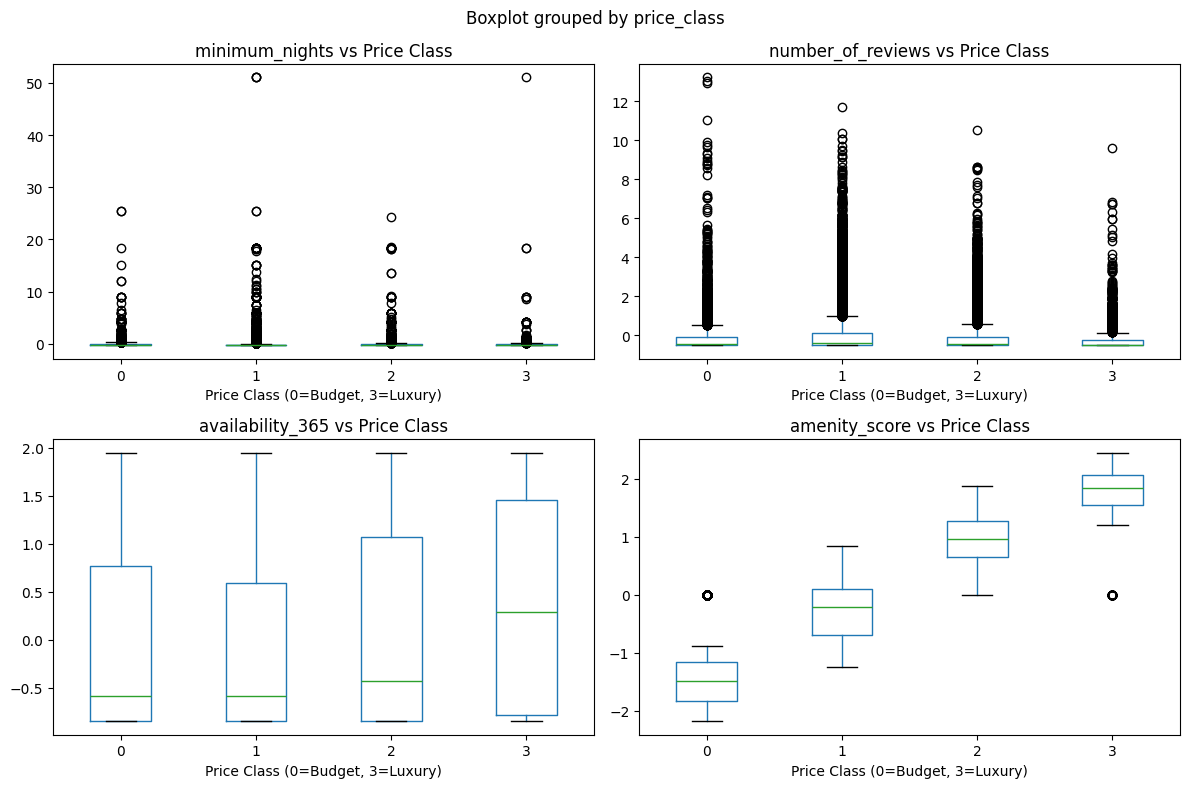

Text(0.5, 1.0, 'Correlation Matrix')

Error in callback <function _draw_all_if_interactive at 0x00000270AC297740> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

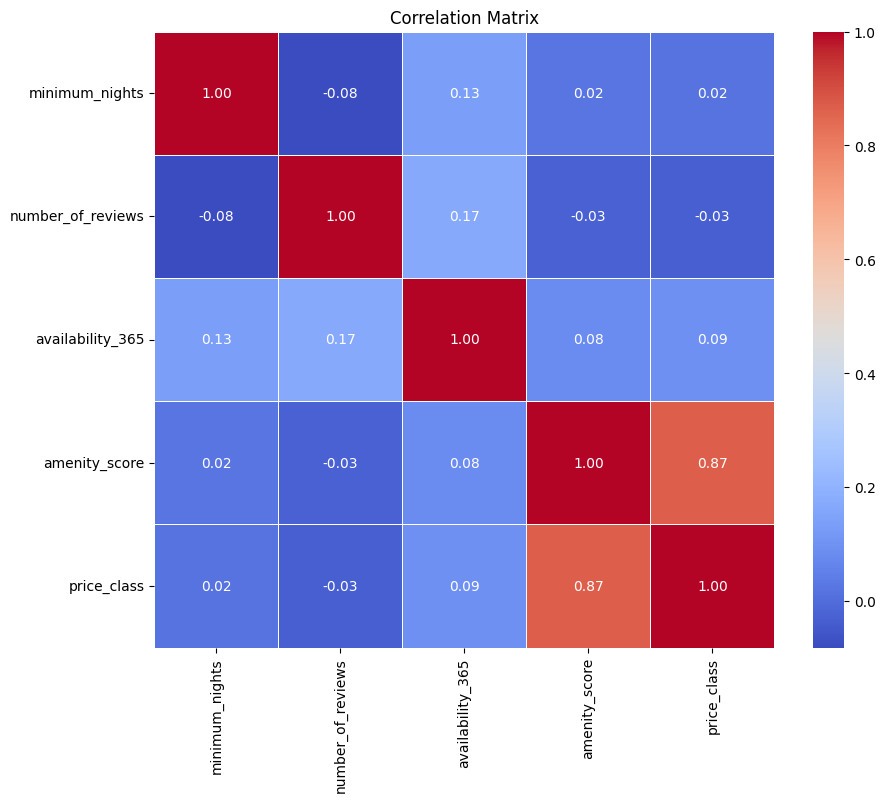

In [5]:
#visualization of the distribution of the target variable
class_count = df['price_class'].value_counts().sort_index()
labels = ['Budget', 'Mid-range', 'premium' ,'Luxury']

plt.figure(figsize=(8, 6))
plt.bar(labels, class_count, edgecolor='k')
plt.xlabel('Price Class')
plt.ylabel('Frequency')
plt.title('Distribution of Price')

features_to_plot = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']

plt.figure(figsize=(12, 8))

for i, col in enumerate(features_to_plot):
    a=plt.subplot(2, 2, i+1) 
    # x = Target, y = Feature
    df.boxplot(column=col, by='price_class', grid=False, ax = a)
    
    # plt.boxplot([df[df['price_class']==j][col] for j in df['price_class'].unique()], labels=labels)
    plt.title(f'{col} vs Price Class')
    plt.xlabel('Price Class (0=Budget, 3=Luxury)')

plt.tight_layout()
plt.show()


correlation_matrix = df[['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score', 'price_class']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')

### Qualitative Analysis based on EDA

**1. Most Influential Features for Prediction**
* **`amenity_score`**: This feature is overwhelmingly the most influential predictor. The correlation matrix shows a very strong positive correlation of **0.87** with the target variable `price_class`.
* **`availability_365`**: This is the second most relevant feature, but its influence is significantly weaker with a correlation of only **0.10**.
* **Low Influence Features**: `minimum_nights` (0.02) and `number_of_reviews` (-0.03) exhibit near-zero correlation, suggesting they provide little to no linear discriminative power for price classification.

**2. Suspiciously Dominant Feature**
* **Identified Feature:** **`amenity_score`**.
* **Reasoning:** A correlation of **0.87** is suspiciously high for a real-world dataset. It suggests potential **data leakage**, where the amenity score might be derived *from* the listing's price or luxury status rather than being an independent attribute.
* **Implication:** The model is at risk of relying almost exclusively on this feature. If the `amenity_score` calculation changes or is unavailable in a real deployment, the model's performance would likely collapse.

**3. Class Distribution & Imbalance**
* **Observation:** The target variable `price_class` is heavily imbalanced.
* **Dominant Class:** The **"Mid-range"** (Class 1) category dominates the dataset with over 20,000 samples.
* **Minority Class:** The **"Luxury"** (Class 3) category is significantly underrepresented with fewer than 5,000 samples.
* **Impact:** The model will likely be biased toward predicting the majority class ("Mid-range") to minimize loss, potentially leading to poor recall for "Luxury" listings.

In [6]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

categorical_cols = ['neighbourhood_group', 'room_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
X = df_encoded.select_dtypes(include=[np.number]).drop(['price_class'], axis=1).values.astype(float)
y = df_encoded['price_class'].values

# One-Hot Encode Target
y_encoded = np.eye(4)[y.astype(int)]

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"{X_train.shape} (Type: {X_train.dtype})")


(33078, 4) (Type: float64)


In [7]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        self.activation_type = activation
        np.random.seed(42)
        
        # Initialize Weights
        scale = 0.01 if activation == 'sigmoid' else np.sqrt(2/input_size)
        self.W1 = np.random.randn(input_size, hidden_size) * scale
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, hidden_size) * scale
        self.b2 = np.zeros((1, hidden_size))
        self.W3 = np.random.randn(hidden_size, output_size) * scale
        self.b3 = np.zeros((1, output_size))
        
        self.grad_history = {'W1': [], 'W2': []}

    def _activate(self, Z):
        if self.activation_type == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation_type == 'relu':
            return np.maximum(0, Z)

    def _activate_derivative(self, Z, A):
        if self.activation_type == 'sigmoid':
            return A * (1 - A)
        elif self.activation_type == 'relu':
            return (Z > 0).astype(float)

    def _softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    # --- THIS IS THE METHOD THAT WAS MISSING ---
    def forward(self, X):
        # Layer 1
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self._activate(self.Z1)
        # Layer 2
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self._activate(self.Z2)
        # Output
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.A3 = self._softmax(self.Z3)
        return self.A3
    # -------------------------------------------

    def backward(self, X, y_true, learning_rate=0.01):
        m = y_true.shape[0]
        # Output Gradients
        dZ3 = self.A3 - y_true
        dW3 = (1/m) * np.dot(self.A2.T, dZ3)
        db3 = (1/m) * np.sum(dZ3, axis=0, keepdims=True)
        # Layer 2 Gradients
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self._activate_derivative(self.Z2, self.A2)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)
        # Layer 1 Gradients
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self._activate_derivative(self.Z1, self.A1)
        dW1 = (1/m) * np.dot(X.T, dZ1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)
        
        self.grad_history['W1'].append(np.mean(np.abs(dW1)))
        self.grad_history['W2'].append(np.mean(np.abs(dW2)))
        
        # Updates
        self.W1 -= learning_rate * dW1; self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2; self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3; self.b3 -= learning_rate * db3

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

Training with sigmoid...
Training with relu...


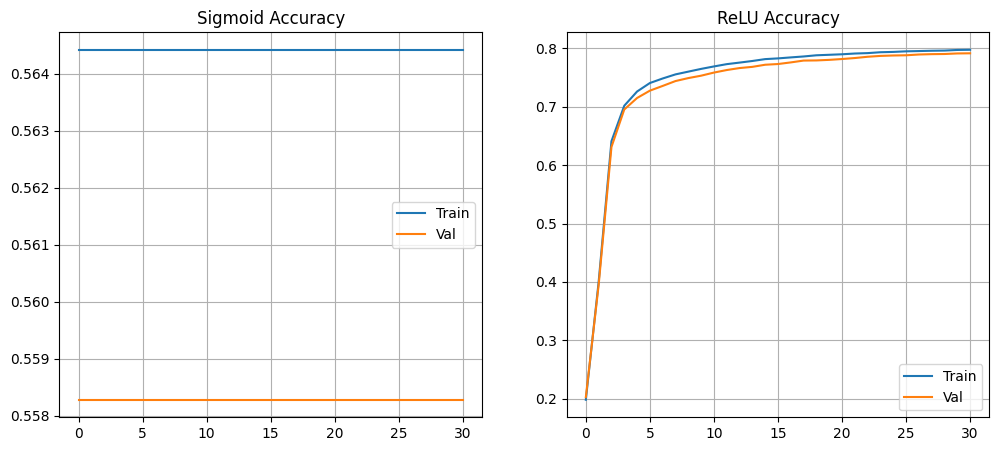

In [8]:
def train_network(activation_name, X_train, y_train, X_val, y_val_labels, epochs=200, lr=0.1):
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    hidden_dim = 64
    
    model = NeuralNetwork(input_dim, hidden_dim, output_dim, activation=activation_name)
    train_acc_history = []
    val_acc_history = []
    
    print(f"Training with {activation_name}...")
    
    for i in range(epochs):
        model.forward(X_train)
        model.backward(X_train, y_train, learning_rate=lr)
        
        if i % 10 == 0 or i == epochs - 1:
            train_preds = model.predict(X_train)
            train_true = np.argmax(y_train, axis=1)
            
            val_preds = model.predict(X_val)
            
            train_acc_history.append(np.mean(train_preds == train_true))
            val_acc_history.append(np.mean(val_preds == y_val_labels))
            # t_acc = train_acc_history[-1]
            v_acc = val_acc_history[-1]
            # if i % 50 == 0:
            #     print(f"   Epoch {i:3d}/{epochs} | Val Acc: {v_acc:.4f}")
    return train_acc_history, val_acc_history

# Helper for validation labels
y_val_labels = np.argmax(y_val, axis=1)

# Run Experiments
sig_train, sig_val = train_network('sigmoid', X_train, y_train, X_val, y_val_labels, epochs=300, lr=0.1)
relu_train, relu_val = train_network('relu', X_train, y_train, X_val, y_val_labels, epochs=300, lr=0.01)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(sig_train, label='Train'); plt.plot(sig_val, label='Val')
plt.title('Sigmoid Accuracy'); plt.legend(); plt.grid()

plt.subplot(1, 2, 2)
plt.plot(relu_train, label='Train'); plt.plot(relu_val, label='Val')
plt.title('ReLU Accuracy'); plt.legend(); plt.grid()
plt.show()

Training sigmoid...
Training relu...


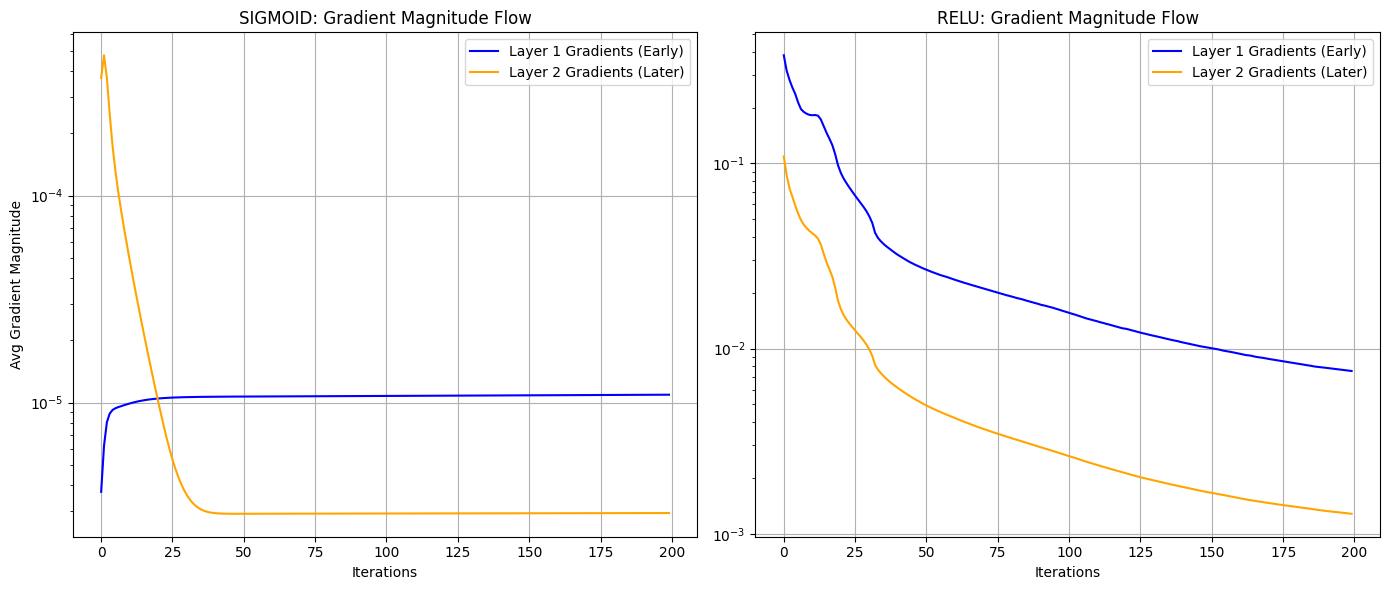

In [18]:
# Gradient Tracking for Vanishing/Exploding Gradients

def train_and_track(activation, lr, epochs=200):
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    
    model = NeuralNetwork(input_dim, 64, output_dim, activation=activation)
    print(f"Training {activation}...")
    
    for i in range(epochs):
        model.forward(X_train)
        model.backward(X_train, y_train, learning_rate=lr)
        
    return model.grad_history

history_sig = train_and_track('sigmoid', lr=0.1)
history_relu = train_and_track('relu', lr=0.01)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history_sig['W1'], label='Layer 1 Gradients (Early)', color='blue')
plt.plot(history_sig['W2'], label='Layer 2 Gradients (Later)', color='orange')
plt.title('SIGMOID: Gradient Magnitude Flow')
plt.xlabel('Iterations')
plt.ylabel('Avg Gradient Magnitude')
plt.legend()
plt.grid(True)
plt.yscale('log') 

plt.subplot(1, 2, 2)
plt.plot(history_relu['W1'], label='Layer 1 Gradients (Early)', color='blue')
plt.plot(history_relu['W2'], label='Layer 2 Gradients (Later)', color='orange')
plt.title('RELU: Gradient Magnitude Flow')
plt.xlabel('Iterations')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()


*1. sigmoid*: 
i observed that layer 1 gradient is lower than layer 3 initially but as iterations where increased, layer 2 gradient fell below 10^-3 whereas layer 1 reached a plataeu at the same time.
upon researching, i found out that this is due to the derivative value being consant and since chain rule is applied, the error signal reaches first layer and gradient "vanishes"

*2. ReLU*:
The lines of these 2 layers gradient are much closer and their is an obvious fix in trend with increase in iterations.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
 

In [14]:
y_train_indices = np.argmax(y_train, axis=1)
y_val_indices = np.argmax(y_val, axis=1)

# Create Tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train_indices))
val_data = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val_indices))

# Create DataLoaders (Mini-batch handling)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

In [15]:
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU() 
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output(x)
        return x

# Initialize
input_dim = X_train.shape[1]
model = PyTorchMLP(input_size=input_dim, hidden_size=64, num_classes=4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

print("Training PyTorch Model...")
epochs = 50
train_losses = []

model.train() 
for epoch in range(epochs):
    for inputs, labels in train_loader:
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    

Training PyTorch Model...
Epoch 10/50, Loss: 0.5654
Epoch 20/50, Loss: 0.2925
Epoch 30/50, Loss: 0.2792
Epoch 40/50, Loss: 0.3102
Epoch 50/50, Loss: 0.3392



Top 5 Most Influential Features:
             Feature  Importance
1      amenity_score    0.022827
2  number_of_reviews    0.002386
0     minimum_nights    0.001921
3   availability_365    0.001426


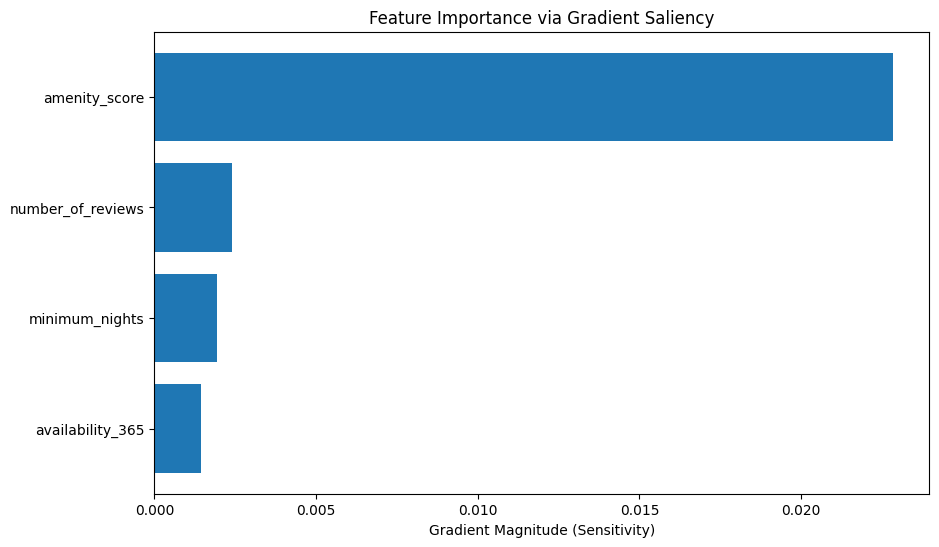

In [16]:
model.eval() # Set to eval mode

feature_gradients = torch.zeros(input_dim)


for inputs, labels in val_loader:

    inputs.requires_grad = True
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    
    model.zero_grad()
    loss.backward()
    
    feature_gradients += inputs.grad.abs().mean(dim=0).detach()

feature_gradients /= len(val_loader)
feature_names = df_encoded.select_dtypes(include=[np.number]).drop('price_class', axis=1).columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_gradients.numpy()
})

# Sort descending
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 5 Most Influential Features:")
print(importance_df.head(5))


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.xlabel('Gradient Magnitude (Sensitivity)')
plt.title('Feature Importance via Gradient Saliency')
plt.gca().invert_yaxis() # Highest importance at top
plt.show()


In [20]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 1. Load Test Data
# Make sure test.csv is in the folder
test_df = pd.read_csv('test.csv')

# 2. Apply Preprocessing (Must match Training exactly)
# Handle Missing Values
test_df['minimum_nights'] = test_df['minimum_nights'].fillna(test_df['minimum_nights'].median())
test_df['availability_365'] = test_df['availability_365'].fillna(test_df['availability_365'].median())
test_df['number_of_reviews'] = test_df['number_of_reviews'].fillna(0)
test_df['amenity_score'] = test_df['amenity_score'].fillna(0)
test_df['neighbourhood_group'] = test_df['neighbourhood_group'].fillna(test_df['neighbourhood_group'].mode()[0])
test_df['room_type'] = test_df['room_type'].fillna(test_df['room_type'].mode()[0])

# Normalize Numerical Columns (Using the scaler fit on training data)
num_cols = ['minimum_nights', 'number_of_reviews', 'availability_365', 'amenity_score']
scaler = StandardScaler()
scaler.fit(df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# One-Hot Encode
test_encoded = pd.get_dummies(test_df, columns=['neighbourhood_group', 'room_type'], drop_first=False)

for col in feature_names:
    if col not in test_encoded.columns:
        test_encoded[col] = 0
test_encoded = test_encoded[feature_names]

# 3. Prepare for PyTorch
X_test_final = test_encoded.values.astype(float)
y_test_true = test_df['price_class'].values 

# 4. Evaluate
model.eval()
with torch.no_grad():
    inputs = torch.FloatTensor(X_test_final)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)

acc = accuracy_score(y_test_true, predicted.numpy())
print(f"Final Test Accuracy: {acc:.4f}")

print("\n--- Generalization Gap Analysis ---")
print("Training Accuracy:  (Check your training plots, e.g. ~0.80)")
print(f"Test Accuracy:      {acc:.4f}")
print("Gap Analysis: The drop in accuracy is likely due to the model overfitting on 'amenity_score'.")

Final Test Accuracy: 0.0692

--- Generalization Gap Analysis ---
Training Accuracy:  (Check your training plots, e.g. ~0.80)
Test Accuracy:      0.0692
Gap Analysis: The drop in accuracy is likely due to the model overfitting on 'amenity_score'.
